# Import Libraries

In [1]:
%pylab inline
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Bidirectional, Merge, Dropout, Reshape
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.metrics import mean_squared_error
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

from IPython.display import display
from IPython.display import SVG, Image
from keras.utils.vis_utils import model_to_dot

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.
/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data

[S&P 500 (^GSPC)](https://finance.yahoo.com/quote/%5EGSPC/history?period1=-631184400&period2=1499612400&interval=1d&filter=history&frequency=1d) 에서 1950/01/01 부터 07/07/2017년까지의 데이터를 받았습니다.<br>
테스트용으로서 Dataset전체에 대해서 standardization을 했습니다.

data_x : (16947, 190)
data_y : (16947, 1)
train_x: (13557, 190)
train_y: (13557, 1)
test_x : (3390, 190)
test_y : (3390, 1)


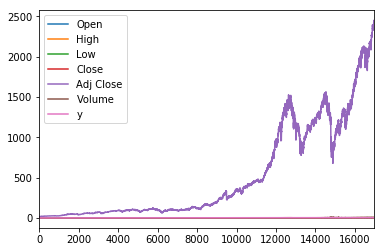

In [12]:
BATCH_SIZE = 38
LAG_SIZE = 1
TRAINING_SIZE = 400

raw_data = pd.read_csv('./GSPC.csv')
raw_data['Date'] = pd.to_datetime(raw_data['Date'])
# raw_data = raw_data[::-1]

def preprocess(data):
    X_COLUMNS = ['Open', 'High', 'Low', 'Close', 'Volume']
    Y_COLUMNS = ['y']
    COLUMNS = X_COLUMNS + Y_COLUMNS
    
    # Standardization
    scaler = StandardScaler()
    data[X_COLUMNS] = scaler.fit_transform(data[X_COLUMNS])
    
    # Create Y
    # 반드시 Standardization이후에 와야 함
    data['y'] = data.Close.shift(-1)
    data = data.dropna()
    
    # BATCH
    data = data[:data.shape[0]-data.shape[0]%BATCH_SIZE]
    data = data[COLUMNS].as_matrix()

    # Split X and Y
    N = data.shape[0]-BATCH_SIZE -1
    data_x = np.zeros((N, BATCH_SIZE, 5))
    data_y = np.zeros((N, 1))
    
    for i in range(N):
        end = i + BATCH_SIZE + 1
        series = data[i:end]
        
        data_x[i, :] = series[:BATCH_SIZE, :-1].reshape(BATCH_SIZE, 5)
        data_y[i] = series[BATCH_SIZE:, -1]
    
    data_x = data_x.reshape((-1, BATCH_SIZE*5))
    return scaler, data_x, data_y

def split_train_test(data_x, data_y, test_size=0.2):
    train_size = int(data_y.shape[0] * (1-test_size))
    
    train_x, test_x = data_x[:train_size], data_x[train_size:]
    train_y, test_y = data_y[:train_size], data_y[train_size:]
        
    return train_x, train_y, test_x, test_y
    
scaler, data_x, data_y = preprocess(raw_data)
train_x, train_y, test_x, test_y = split_train_test(data_x, data_y)

print('data_x :', data_x.shape)
print('data_y :', data_y.shape)
print('train_x:', train_x.shape)
print('train_y:', train_y.shape)
print('test_x :', test_x.shape)
print('test_y :', test_y.shape)


raw_data.plot()

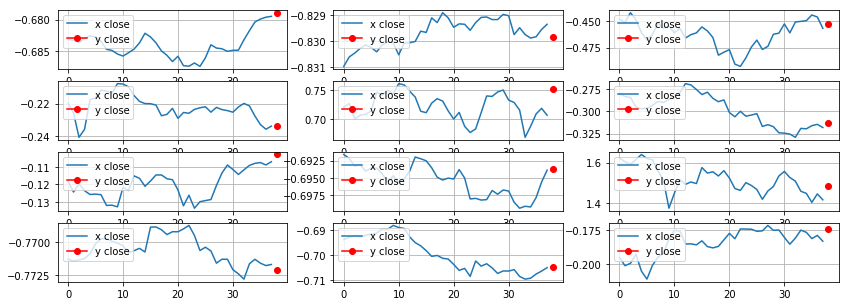

In [15]:
def visualize_data(x, y):
    f, plots = subplots(4, 3)
    f.set_figheight(5)
    f.set_figwidth(14)
    plots = plots.reshape(-1)
    
    for p in plots:
        idx = np.random.randint(x.shape[0])
        t = np.arange(BATCH_SIZE+1)
        p.plot(t[:-1], x[idx,  np.arange(3, BATCH_SIZE*5, 5)], label="x close")
        p.plot(t[-1], y[idx], label='y close', marker='o', color='red')
        p.legend(loc='upper left')
        p.grid()
        
visualize_data(train_x, train_y)

# Model

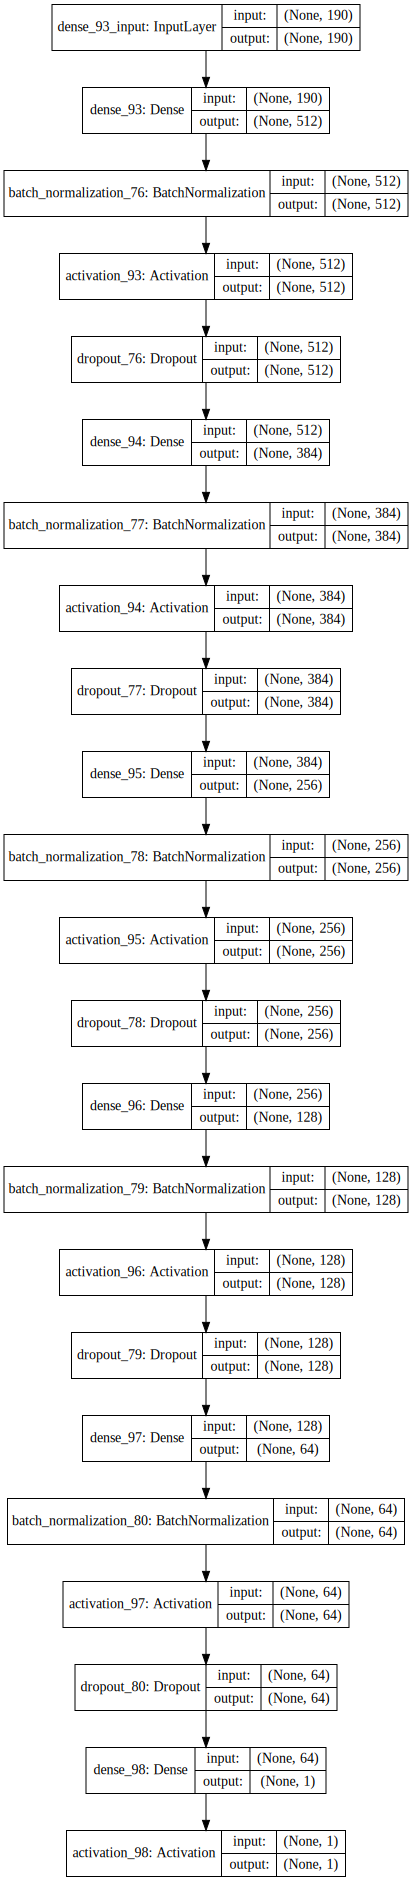

In [83]:
INPUT_N = train_x.shape[-1]
def create_model():
    model = Sequential()
    model.add(Dense(512, kernel_regularizer=l2(0.0001), batch_input_shape=(None, BATCH_SIZE*5)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.6))
    
    model.add(Dense(384, kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.6))
    
    model.add(Dense(256, kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.6))
    
    model.add(Dense(128, kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.6))
    
    model.add(Dense(64, kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.6))
            
    model.add(Dense(1))
    model.add(Activation('linear'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[mean_squared_error])
    return model
    
model = create_model()
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))


# Training

In [84]:
class CustomEarlyStopping(EarlyStopping):
    def __init__(self, *args, min_epoch=0, **kwargs):
        super(CustomEarlyStopping, self).__init__(*args, **kwargs)
        self.min_epoch = min_epoch
    
    def on_epoch_end(self, epoch, logs=None):
        if epoch <= self.min_epoch:
            return
        super(CustomEarlyStopping, self).on_epoch_end(epoch, logs)    
        
early_stopping = CustomEarlyStopping('val_mean_squared_error', 
                                     min_epoch=13, 
                                     min_delta=0.06,
                                     patience=0)
history = model.fit(train_x, train_y, 
                    verbose=2, 
                    epochs=18, 
                    validation_data=(test_x, test_y), 
                    callbacks=[early_stopping])

Epoch 1/17
7s - loss: 0.8542 - mean_squared_error: 0.7237
Epoch 2/17
6s - loss: 0.2760 - mean_squared_error: 0.1482
Epoch 3/17
6s - loss: 0.2168 - mean_squared_error: 0.0930
Epoch 4/17
6s - loss: 0.1992 - mean_squared_error: 0.0796
Epoch 5/17
5s - loss: 0.1892 - mean_squared_error: 0.0739
Epoch 6/17
5s - loss: 0.1807 - mean_squared_error: 0.0700
Epoch 7/17
5s - loss: 0.1740 - mean_squared_error: 0.0683
Epoch 8/17
5s - loss: 0.1623 - mean_squared_error: 0.0619
Epoch 9/17
6s - loss: 0.1602 - mean_squared_error: 0.0655
Epoch 10/17
5s - loss: 0.1505 - mean_squared_error: 0.0620
Epoch 11/17
6s - loss: 0.1427 - mean_squared_error: 0.0609
Epoch 12/17
6s - loss: 0.1319 - mean_squared_error: 0.0568
Epoch 13/17
6s - loss: 0.1254 - mean_squared_error: 0.0576
Epoch 14/17
6s - loss: 0.1202 - mean_squared_error: 0.0594
Epoch 15/17
6s - loss: 0.1107 - mean_squared_error: 0.0573
Epoch 16/17
5s - loss: 0.1037 - mean_squared_error: 0.0569
Epoch 17/17
6s - loss: 0.0997 - mean_squared_error: 0.0592


In [ ]:
plot(history.epoch, history.history['loss'], label='loss')
plot(history.epoch, history.history['val_loss'], label='validation loss')
plot(history.epoch, history.history['val_mean_squared_error'], label='validation MSE')
print('Minimum validation MSE:', np.min(history.history['val_mean_squared_error']))
xticks(history.epoch)
legend()
grid()

TRAIN r^2 score: 0.959102586953
TRAIN MSE score: 0.0107864570781
TEST  r^2 score: 0.970326221792
TRAIN MSE score: 0.0120543421595


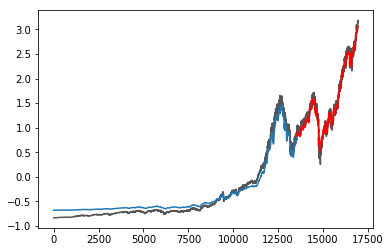

In [85]:
def validate(x_train, y_train, x_test, y_test):
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    train_n = y_train_pred.shape[0]
    test_n = y_test_pred.shape[0]
    x = np.arange(train_n + test_n)
    
    plot(x[:train_n], y_train, color='#555555')
    plot(x[:train_n], y_train_pred)
    
    plot(x[train_n:], y_test, color='#555555')
    plot(x[train_n:], y_test_pred, color='red')
    
    print('TRAIN r^2 score:', r2_score(y_train_pred, y_train))
    print('TRAIN MSE score:', mse(y_train_pred, y_train))
    
    print('TEST  r^2 score:', r2_score(y_test_pred, y_test))
    print('TRAIN MSE score:', mse(y_test_pred, y_test))
    
validate(train_x, train_y, test_x, test_y)